In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 512),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 47361


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.05),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=200,
    patience=200,
    delta=0,
    batch_size=1024,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 41/41 [00:00<00:00, 82.78it/s]


Epoch   1/200: RMSE_train: 1,736,930, RMSE_val: 1,727,640


100%|██████████| 41/41 [00:00<00:00, 79.67it/s]


Epoch   2/200: RMSE_train: 1,731,158, RMSE_val: 1,727,888
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 95.87it/s]


Epoch   3/200: RMSE_train: 1,733,542, RMSE_val: 1,723,592


100%|██████████| 41/41 [00:00<00:00, 84.60it/s]


Epoch   4/200: RMSE_train: 1,725,479, RMSE_val: 1,716,529


100%|██████████| 41/41 [00:00<00:00, 87.52it/s]


Epoch   5/200: RMSE_train: 1,719,821, RMSE_val: 1,717,505
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.47it/s]


Epoch   6/200: RMSE_train: 1,713,976, RMSE_val: 1,708,360


100%|██████████| 41/41 [00:00<00:00, 78.47it/s]


Epoch   7/200: RMSE_train: 1,701,978, RMSE_val: 1,696,843


100%|██████████| 41/41 [00:00<00:00, 94.32it/s]


Epoch   8/200: RMSE_train: 1,692,201, RMSE_val: 1,688,947


100%|██████████| 41/41 [00:00<00:00, 82.41it/s]


Epoch   9/200: RMSE_train: 1,676,951, RMSE_val: 1,685,185


100%|██████████| 41/41 [00:00<00:00, 83.32it/s]


Epoch  10/200: RMSE_train: 1,661,461, RMSE_val: 1,671,470


100%|██████████| 41/41 [00:00<00:00, 86.33it/s]


Epoch  11/200: RMSE_train: 1,647,370, RMSE_val: 1,658,595


100%|██████████| 41/41 [00:00<00:00, 69.94it/s]


Epoch  12/200: RMSE_train: 1,632,461, RMSE_val: 1,637,937


100%|██████████| 41/41 [00:00<00:00, 76.91it/s]


Epoch  13/200: RMSE_train: 1,612,933, RMSE_val: 1,628,593


100%|██████████| 41/41 [00:00<00:00, 91.98it/s]


Epoch  14/200: RMSE_train: 1,591,130, RMSE_val: 1,618,954


100%|██████████| 41/41 [00:00<00:00, 83.12it/s]


Epoch  15/200: RMSE_train: 1,572,717, RMSE_val: 1,589,016


100%|██████████| 41/41 [00:00<00:00, 93.37it/s]


Epoch  16/200: RMSE_train: 1,549,451, RMSE_val: 1,574,152


100%|██████████| 41/41 [00:00<00:00, 78.46it/s]


Epoch  17/200: RMSE_train: 1,526,246, RMSE_val: 1,563,828


100%|██████████| 41/41 [00:00<00:00, 83.58it/s]


Epoch  18/200: RMSE_train: 1,505,265, RMSE_val: 1,546,474


100%|██████████| 41/41 [00:00<00:00, 96.30it/s]


Epoch  19/200: RMSE_train: 1,479,041, RMSE_val: 1,517,184


100%|██████████| 41/41 [00:00<00:00, 78.78it/s]


Epoch  20/200: RMSE_train: 1,451,398, RMSE_val: 1,502,788


100%|██████████| 41/41 [00:00<00:00, 60.75it/s]


Epoch  21/200: RMSE_train: 1,424,901, RMSE_val: 1,494,425


100%|██████████| 41/41 [00:00<00:00, 92.78it/s]


Epoch  22/200: RMSE_train: 1,397,840, RMSE_val: 1,469,286


100%|██████████| 41/41 [00:00<00:00, 59.98it/s]


Epoch  23/200: RMSE_train: 1,369,397, RMSE_val: 1,452,532


100%|██████████| 41/41 [00:00<00:00, 81.14it/s]


Epoch  24/200: RMSE_train: 1,339,003, RMSE_val: 1,414,525


100%|██████████| 41/41 [00:00<00:00, 81.21it/s]


Epoch  25/200: RMSE_train: 1,309,008, RMSE_val: 1,405,466


100%|██████████| 41/41 [00:00<00:00, 81.35it/s]


Epoch  26/200: RMSE_train: 1,285,672, RMSE_val: 1,412,281
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.46it/s]


Epoch  27/200: RMSE_train: 1,252,382, RMSE_val: 1,372,946


100%|██████████| 41/41 [00:00<00:00, 89.86it/s]


Epoch  28/200: RMSE_train: 1,221,033, RMSE_val: 1,342,290


100%|██████████| 41/41 [00:00<00:00, 78.99it/s]


Epoch  29/200: RMSE_train: 1,190,004, RMSE_val: 1,339,698


100%|██████████| 41/41 [00:00<00:00, 74.87it/s]


Epoch  30/200: RMSE_train: 1,162,525, RMSE_val: 1,324,339


100%|██████████| 41/41 [00:00<00:00, 90.62it/s]


Epoch  31/200: RMSE_train: 1,128,111, RMSE_val: 1,302,493


100%|██████████| 41/41 [00:00<00:00, 80.40it/s]


Epoch  32/200: RMSE_train: 1,097,977, RMSE_val: 1,269,580


100%|██████████| 41/41 [00:00<00:00, 81.42it/s]


Epoch  33/200: RMSE_train: 1,069,166, RMSE_val: 1,256,194


100%|██████████| 41/41 [00:00<00:00, 91.06it/s]


Epoch  34/200: RMSE_train: 1,037,972, RMSE_val: 1,245,508


100%|██████████| 41/41 [00:00<00:00, 80.15it/s]


Epoch  35/200: RMSE_train: 1,010,916, RMSE_val: 1,223,420


100%|██████████| 41/41 [00:00<00:00, 89.79it/s]


Epoch  36/200: RMSE_train: 978,203, RMSE_val: 1,209,862


100%|██████████| 41/41 [00:00<00:00, 93.40it/s]


Epoch  37/200: RMSE_train: 949,143, RMSE_val: 1,172,975


100%|██████████| 41/41 [00:00<00:00, 87.20it/s]


Epoch  38/200: RMSE_train: 924,077, RMSE_val: 1,182,055
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 87.83it/s]


Epoch  39/200: RMSE_train: 896,805, RMSE_val: 1,161,226


100%|██████████| 41/41 [00:00<00:00, 93.38it/s]


Epoch  40/200: RMSE_train: 868,573, RMSE_val: 1,166,190
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.38it/s]


Epoch  41/200: RMSE_train: 842,327, RMSE_val: 1,133,014


100%|██████████| 41/41 [00:00<00:00, 86.42it/s]


Epoch  42/200: RMSE_train: 821,169, RMSE_val: 1,133,638
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.87it/s]


Epoch  43/200: RMSE_train: 794,910, RMSE_val: 1,116,347


100%|██████████| 41/41 [00:00<00:00, 79.55it/s]


Epoch  44/200: RMSE_train: 770,453, RMSE_val: 1,105,556


100%|██████████| 41/41 [00:00<00:00, 92.33it/s]


Epoch  45/200: RMSE_train: 751,286, RMSE_val: 1,100,578


100%|██████████| 41/41 [00:00<00:00, 75.98it/s]


Epoch  46/200: RMSE_train: 730,583, RMSE_val: 1,109,447
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.32it/s]


Epoch  47/200: RMSE_train: 707,399, RMSE_val: 1,108,662
EarlyStopping counter: 2 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.86it/s]


Epoch  48/200: RMSE_train: 688,908, RMSE_val: 1,099,842


100%|██████████| 41/41 [00:00<00:00, 73.60it/s]


Epoch  49/200: RMSE_train: 671,471, RMSE_val: 1,095,076


100%|██████████| 41/41 [00:00<00:00, 80.43it/s]


Epoch  50/200: RMSE_train: 655,622, RMSE_val: 1,063,920


100%|██████████| 41/41 [00:00<00:00, 92.04it/s]


Epoch  51/200: RMSE_train: 642,324, RMSE_val: 1,061,655


100%|██████████| 41/41 [00:00<00:00, 75.88it/s]


Epoch  52/200: RMSE_train: 624,731, RMSE_val: 1,061,755
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.31it/s]


Epoch  53/200: RMSE_train: 612,652, RMSE_val: 1,056,268


100%|██████████| 41/41 [00:00<00:00, 79.02it/s]


Epoch  54/200: RMSE_train: 603,439, RMSE_val: 1,045,319


100%|██████████| 41/41 [00:00<00:00, 78.41it/s]


Epoch  55/200: RMSE_train: 591,239, RMSE_val: 1,043,350


100%|██████████| 41/41 [00:00<00:00, 86.81it/s]


Epoch  56/200: RMSE_train: 577,969, RMSE_val: 1,060,844
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.62it/s]


Epoch  57/200: RMSE_train: 571,723, RMSE_val: 1,063,522
EarlyStopping counter: 2 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.07it/s]


Epoch  58/200: RMSE_train: 562,691, RMSE_val: 1,048,779
EarlyStopping counter: 3 out of 200


100%|██████████| 41/41 [00:00<00:00, 86.87it/s]


Epoch  59/200: RMSE_train: 555,363, RMSE_val: 1,054,636
EarlyStopping counter: 4 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.80it/s]


Epoch  60/200: RMSE_train: 548,851, RMSE_val: 1,025,507


100%|██████████| 41/41 [00:00<00:00, 78.95it/s]


Epoch  61/200: RMSE_train: 539,293, RMSE_val: 1,051,704
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.31it/s]


Epoch  62/200: RMSE_train: 530,897, RMSE_val: 1,031,171
EarlyStopping counter: 2 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.17it/s]


Epoch  63/200: RMSE_train: 532,657, RMSE_val: 1,030,985
EarlyStopping counter: 3 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.08it/s]


Epoch  64/200: RMSE_train: 524,194, RMSE_val: 1,030,993
EarlyStopping counter: 4 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.63it/s]


Epoch  65/200: RMSE_train: 519,695, RMSE_val: 1,032,868
EarlyStopping counter: 5 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.74it/s]


Epoch  66/200: RMSE_train: 516,982, RMSE_val: 1,027,659
EarlyStopping counter: 6 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.79it/s]


Epoch  67/200: RMSE_train: 514,440, RMSE_val: 1,033,468
EarlyStopping counter: 7 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.01it/s]


Epoch  68/200: RMSE_train: 510,355, RMSE_val: 1,025,928
EarlyStopping counter: 8 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.60it/s]


Epoch  69/200: RMSE_train: 504,455, RMSE_val: 1,024,772


100%|██████████| 41/41 [00:00<00:00, 77.25it/s]


Epoch  70/200: RMSE_train: 501,587, RMSE_val: 1,019,521


100%|██████████| 41/41 [00:00<00:00, 89.69it/s]


Epoch  71/200: RMSE_train: 499,895, RMSE_val: 1,022,403
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.41it/s]


Epoch  72/200: RMSE_train: 494,758, RMSE_val: 1,040,434
EarlyStopping counter: 2 out of 200


100%|██████████| 41/41 [00:00<00:00, 84.65it/s]


Epoch  73/200: RMSE_train: 498,886, RMSE_val: 1,023,181
EarlyStopping counter: 3 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.53it/s]


Epoch  74/200: RMSE_train: 496,586, RMSE_val: 1,041,877
EarlyStopping counter: 4 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.13it/s]


Epoch  75/200: RMSE_train: 489,635, RMSE_val: 1,057,935
EarlyStopping counter: 5 out of 200


100%|██████████| 41/41 [00:00<00:00, 83.22it/s]


Epoch  76/200: RMSE_train: 490,863, RMSE_val: 1,094,490
EarlyStopping counter: 6 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.47it/s]


Epoch  77/200: RMSE_train: 490,625, RMSE_val: 1,030,482
EarlyStopping counter: 7 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.59it/s]


Epoch  78/200: RMSE_train: 484,010, RMSE_val: 1,032,695
EarlyStopping counter: 8 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.87it/s]


Epoch  79/200: RMSE_train: 485,209, RMSE_val: 1,033,727
EarlyStopping counter: 9 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.91it/s]


Epoch  80/200: RMSE_train: 487,993, RMSE_val: 1,034,639
EarlyStopping counter: 10 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.24it/s]


Epoch  81/200: RMSE_train: 484,944, RMSE_val: 1,039,264
EarlyStopping counter: 11 out of 200


100%|██████████| 41/41 [00:00<00:00, 87.01it/s]


Epoch  82/200: RMSE_train: 481,287, RMSE_val: 1,036,183
EarlyStopping counter: 12 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.40it/s]


Epoch  83/200: RMSE_train: 480,963, RMSE_val: 1,040,233
EarlyStopping counter: 13 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.68it/s]


Epoch  84/200: RMSE_train: 487,171, RMSE_val: 1,045,876
EarlyStopping counter: 14 out of 200


100%|██████████| 41/41 [00:00<00:00, 87.42it/s]


Epoch  85/200: RMSE_train: 480,426, RMSE_val: 1,033,042
EarlyStopping counter: 15 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.42it/s]


Epoch  86/200: RMSE_train: 476,706, RMSE_val: 1,016,140


100%|██████████| 41/41 [00:00<00:00, 80.09it/s]


Epoch  87/200: RMSE_train: 474,671, RMSE_val: 1,027,468
EarlyStopping counter: 1 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.28it/s]


Epoch  88/200: RMSE_train: 476,524, RMSE_val: 1,023,225
EarlyStopping counter: 2 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.94it/s]


Epoch  89/200: RMSE_train: 475,436, RMSE_val: 1,034,073
EarlyStopping counter: 3 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.57it/s]


Epoch  90/200: RMSE_train: 479,338, RMSE_val: 1,032,257
EarlyStopping counter: 4 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.00it/s]


Epoch  91/200: RMSE_train: 473,908, RMSE_val: 1,032,770
EarlyStopping counter: 5 out of 200


100%|██████████| 41/41 [00:00<00:00, 74.24it/s]


Epoch  92/200: RMSE_train: 470,051, RMSE_val: 1,037,260
EarlyStopping counter: 6 out of 200


100%|██████████| 41/41 [00:00<00:00, 89.70it/s]


Epoch  93/200: RMSE_train: 472,245, RMSE_val: 1,035,016
EarlyStopping counter: 7 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.82it/s]


Epoch  94/200: RMSE_train: 474,394, RMSE_val: 1,063,676
EarlyStopping counter: 8 out of 200


100%|██████████| 41/41 [00:00<00:00, 74.99it/s]


Epoch  95/200: RMSE_train: 472,941, RMSE_val: 1,030,343
EarlyStopping counter: 9 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.74it/s]


Epoch  96/200: RMSE_train: 471,597, RMSE_val: 1,046,928
EarlyStopping counter: 10 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.13it/s]


Epoch  97/200: RMSE_train: 472,832, RMSE_val: 1,071,755
EarlyStopping counter: 11 out of 200


100%|██████████| 41/41 [00:00<00:00, 76.91it/s]


Epoch  98/200: RMSE_train: 468,996, RMSE_val: 1,052,916
EarlyStopping counter: 12 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.10it/s]


Epoch  99/200: RMSE_train: 466,739, RMSE_val: 1,045,654
EarlyStopping counter: 13 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.31it/s]


Epoch 100/200: RMSE_train: 466,547, RMSE_val: 1,070,014
EarlyStopping counter: 14 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.11it/s]


Epoch 101/200: RMSE_train: 465,789, RMSE_val: 1,034,800
EarlyStopping counter: 15 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.93it/s]


Epoch 102/200: RMSE_train: 461,746, RMSE_val: 1,044,334
EarlyStopping counter: 16 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.27it/s]


Epoch 103/200: RMSE_train: 466,842, RMSE_val: 1,045,395
EarlyStopping counter: 17 out of 200


100%|██████████| 41/41 [00:00<00:00, 76.62it/s]


Epoch 104/200: RMSE_train: 466,180, RMSE_val: 1,057,022
EarlyStopping counter: 18 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.02it/s]


Epoch 105/200: RMSE_train: 465,265, RMSE_val: 1,037,911
EarlyStopping counter: 19 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.83it/s]


Epoch 106/200: RMSE_train: 466,881, RMSE_val: 1,076,673
EarlyStopping counter: 20 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.73it/s]


Epoch 107/200: RMSE_train: 462,460, RMSE_val: 1,036,843
EarlyStopping counter: 21 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.87it/s]


Epoch 108/200: RMSE_train: 468,366, RMSE_val: 1,035,833
EarlyStopping counter: 22 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.89it/s]


Epoch 109/200: RMSE_train: 471,486, RMSE_val: 1,034,291
EarlyStopping counter: 23 out of 200


100%|██████████| 41/41 [00:00<00:00, 86.21it/s]


Epoch 110/200: RMSE_train: 463,791, RMSE_val: 1,169,578
EarlyStopping counter: 24 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.99it/s]


Epoch 111/200: RMSE_train: 460,787, RMSE_val: 1,064,245
EarlyStopping counter: 25 out of 200


100%|██████████| 41/41 [00:00<00:00, 93.22it/s]


Epoch 112/200: RMSE_train: 460,080, RMSE_val: 1,071,241
EarlyStopping counter: 26 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.30it/s]


Epoch 113/200: RMSE_train: 464,321, RMSE_val: 1,036,371
EarlyStopping counter: 27 out of 200


100%|██████████| 41/41 [00:00<00:00, 93.85it/s]


Epoch 114/200: RMSE_train: 460,377, RMSE_val: 1,038,603
EarlyStopping counter: 28 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.63it/s]


Epoch 115/200: RMSE_train: 459,518, RMSE_val: 1,052,093
EarlyStopping counter: 29 out of 200


100%|██████████| 41/41 [00:00<00:00, 86.10it/s]


Epoch 116/200: RMSE_train: 460,196, RMSE_val: 1,028,869
EarlyStopping counter: 30 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.14it/s]


Epoch 117/200: RMSE_train: 462,178, RMSE_val: 1,059,990
EarlyStopping counter: 31 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.81it/s]


Epoch 118/200: RMSE_train: 464,131, RMSE_val: 1,022,474
EarlyStopping counter: 32 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.11it/s]


Epoch 119/200: RMSE_train: 458,790, RMSE_val: 1,041,688
EarlyStopping counter: 33 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.00it/s]


Epoch 120/200: RMSE_train: 457,497, RMSE_val: 1,039,252
EarlyStopping counter: 34 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.60it/s]


Epoch 121/200: RMSE_train: 463,769, RMSE_val: 1,016,269
EarlyStopping counter: 35 out of 200


100%|██████████| 41/41 [00:00<00:00, 93.97it/s]


Epoch 122/200: RMSE_train: 460,270, RMSE_val: 1,028,114
EarlyStopping counter: 36 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.17it/s]


Epoch 123/200: RMSE_train: 461,700, RMSE_val: 1,022,277
EarlyStopping counter: 37 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.69it/s]


Epoch 124/200: RMSE_train: 454,309, RMSE_val: 1,020,838
EarlyStopping counter: 38 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.41it/s]


Epoch 125/200: RMSE_train: 454,012, RMSE_val: 1,018,871
EarlyStopping counter: 39 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.12it/s]


Epoch 126/200: RMSE_train: 452,173, RMSE_val: 1,037,786
EarlyStopping counter: 40 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.55it/s]


Epoch 127/200: RMSE_train: 458,550, RMSE_val: 1,028,560
EarlyStopping counter: 41 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.30it/s]


Epoch 128/200: RMSE_train: 457,040, RMSE_val: 1,030,910
EarlyStopping counter: 42 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.06it/s]


Epoch 129/200: RMSE_train: 454,128, RMSE_val: 1,031,841
EarlyStopping counter: 43 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.75it/s]


Epoch 130/200: RMSE_train: 462,302, RMSE_val: 1,085,438
EarlyStopping counter: 44 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.76it/s]


Epoch 131/200: RMSE_train: 456,373, RMSE_val: 1,030,959
EarlyStopping counter: 45 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.34it/s]


Epoch 132/200: RMSE_train: 452,316, RMSE_val: 1,034,728
EarlyStopping counter: 46 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.52it/s]


Epoch 133/200: RMSE_train: 451,770, RMSE_val: 1,026,529
EarlyStopping counter: 47 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.62it/s]


Epoch 134/200: RMSE_train: 457,425, RMSE_val: 1,025,395
EarlyStopping counter: 48 out of 200


100%|██████████| 41/41 [00:00<00:00, 74.15it/s]


Epoch 135/200: RMSE_train: 455,599, RMSE_val: 1,034,425
EarlyStopping counter: 49 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.05it/s]


Epoch 136/200: RMSE_train: 454,746, RMSE_val: 1,031,323
EarlyStopping counter: 50 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.05it/s]


Epoch 137/200: RMSE_train: 450,179, RMSE_val: 1,019,606
EarlyStopping counter: 51 out of 200


100%|██████████| 41/41 [00:00<00:00, 73.15it/s]


Epoch 138/200: RMSE_train: 456,696, RMSE_val: 1,034,540
EarlyStopping counter: 52 out of 200


100%|██████████| 41/41 [00:00<00:00, 72.70it/s]


Epoch 139/200: RMSE_train: 449,639, RMSE_val: 1,049,093
EarlyStopping counter: 53 out of 200


100%|██████████| 41/41 [00:00<00:00, 76.79it/s]


Epoch 140/200: RMSE_train: 450,522, RMSE_val: 1,035,876
EarlyStopping counter: 54 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.79it/s]


Epoch 141/200: RMSE_train: 452,251, RMSE_val: 1,046,594
EarlyStopping counter: 55 out of 200


100%|██████████| 41/41 [00:00<00:00, 83.37it/s]


Epoch 142/200: RMSE_train: 452,136, RMSE_val: 1,035,066
EarlyStopping counter: 56 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.96it/s]


Epoch 143/200: RMSE_train: 454,039, RMSE_val: 1,032,669
EarlyStopping counter: 57 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.28it/s]


Epoch 144/200: RMSE_train: 456,662, RMSE_val: 1,034,547
EarlyStopping counter: 58 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.42it/s]


Epoch 145/200: RMSE_train: 449,907, RMSE_val: 1,031,956
EarlyStopping counter: 59 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.06it/s]


Epoch 146/200: RMSE_train: 457,182, RMSE_val: 1,023,753
EarlyStopping counter: 60 out of 200


100%|██████████| 41/41 [00:00<00:00, 81.75it/s]


Epoch 147/200: RMSE_train: 451,746, RMSE_val: 1,028,717
EarlyStopping counter: 61 out of 200


100%|██████████| 41/41 [00:00<00:00, 92.88it/s]


Epoch 148/200: RMSE_train: 453,236, RMSE_val: 1,024,954
EarlyStopping counter: 62 out of 200


100%|██████████| 41/41 [00:00<00:00, 88.66it/s]


Epoch 149/200: RMSE_train: 452,488, RMSE_val: 1,041,643
EarlyStopping counter: 63 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.73it/s]


Epoch 150/200: RMSE_train: 454,362, RMSE_val: 1,051,703
EarlyStopping counter: 64 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.78it/s]


Epoch 151/200: RMSE_train: 447,803, RMSE_val: 1,066,702
EarlyStopping counter: 65 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.59it/s]


Epoch 152/200: RMSE_train: 452,837, RMSE_val: 1,063,138
EarlyStopping counter: 66 out of 200


100%|██████████| 41/41 [00:00<00:00, 86.85it/s]


Epoch 153/200: RMSE_train: 451,175, RMSE_val: 1,038,482
EarlyStopping counter: 67 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.87it/s]


Epoch 154/200: RMSE_train: 447,352, RMSE_val: 1,039,089
EarlyStopping counter: 68 out of 200


100%|██████████| 41/41 [00:00<00:00, 74.71it/s]


Epoch 155/200: RMSE_train: 448,147, RMSE_val: 1,033,101
EarlyStopping counter: 69 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.23it/s]


Epoch 156/200: RMSE_train: 448,756, RMSE_val: 1,062,152
EarlyStopping counter: 70 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.61it/s]


Epoch 157/200: RMSE_train: 449,686, RMSE_val: 1,050,440
EarlyStopping counter: 71 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.58it/s]


Epoch 158/200: RMSE_train: 450,377, RMSE_val: 1,044,699
EarlyStopping counter: 72 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.63it/s]


Epoch 159/200: RMSE_train: 447,803, RMSE_val: 1,048,090
EarlyStopping counter: 73 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.31it/s]


Epoch 160/200: RMSE_train: 447,380, RMSE_val: 1,068,140
EarlyStopping counter: 74 out of 200


100%|██████████| 41/41 [00:00<00:00, 73.28it/s]


Epoch 161/200: RMSE_train: 449,006, RMSE_val: 1,057,925
EarlyStopping counter: 75 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.67it/s]


Epoch 162/200: RMSE_train: 448,264, RMSE_val: 1,040,384
EarlyStopping counter: 76 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.27it/s]


Epoch 163/200: RMSE_train: 448,726, RMSE_val: 1,042,800
EarlyStopping counter: 77 out of 200


100%|██████████| 41/41 [00:00<00:00, 91.20it/s]


Epoch 164/200: RMSE_train: 451,924, RMSE_val: 1,034,617
EarlyStopping counter: 78 out of 200


100%|██████████| 41/41 [00:00<00:00, 75.09it/s]


Epoch 165/200: RMSE_train: 447,651, RMSE_val: 1,034,086
EarlyStopping counter: 79 out of 200


100%|██████████| 41/41 [00:00<00:00, 77.87it/s]


Epoch 166/200: RMSE_train: 447,945, RMSE_val: 1,047,933
EarlyStopping counter: 80 out of 200


100%|██████████| 41/41 [00:00<00:00, 88.51it/s]


Epoch 167/200: RMSE_train: 445,428, RMSE_val: 1,041,201
EarlyStopping counter: 81 out of 200


100%|██████████| 41/41 [00:00<00:00, 79.96it/s]


Epoch 168/200: RMSE_train: 449,601, RMSE_val: 1,054,458
EarlyStopping counter: 82 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.73it/s]


Epoch 169/200: RMSE_train: 443,602, RMSE_val: 1,047,376
EarlyStopping counter: 83 out of 200


100%|██████████| 41/41 [00:00<00:00, 90.23it/s]


Epoch 170/200: RMSE_train: 448,821, RMSE_val: 1,045,967
EarlyStopping counter: 84 out of 200


100%|██████████| 41/41 [00:00<00:00, 64.31it/s]


Epoch 171/200: RMSE_train: 445,560, RMSE_val: 1,043,135
EarlyStopping counter: 85 out of 200


100%|██████████| 41/41 [00:00<00:00, 62.80it/s]


Epoch 172/200: RMSE_train: 443,769, RMSE_val: 1,034,593
EarlyStopping counter: 86 out of 200


100%|██████████| 41/41 [00:00<00:00, 82.49it/s]


Epoch 173/200: RMSE_train: 443,619, RMSE_val: 1,061,286
EarlyStopping counter: 87 out of 200


100%|██████████| 41/41 [00:00<00:00, 83.96it/s]


Epoch 174/200: RMSE_train: 447,713, RMSE_val: 1,032,312
EarlyStopping counter: 88 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.88it/s]


Epoch 175/200: RMSE_train: 448,113, RMSE_val: 1,033,946
EarlyStopping counter: 89 out of 200


100%|██████████| 41/41 [00:00<00:00, 88.73it/s]


Epoch 176/200: RMSE_train: 447,496, RMSE_val: 1,058,057
EarlyStopping counter: 90 out of 200


100%|██████████| 41/41 [00:00<00:00, 83.01it/s]


Epoch 177/200: RMSE_train: 443,752, RMSE_val: 1,061,193
EarlyStopping counter: 91 out of 200


100%|██████████| 41/41 [00:00<00:00, 84.03it/s]


Epoch 178/200: RMSE_train: 441,154, RMSE_val: 1,082,419
EarlyStopping counter: 92 out of 200


100%|██████████| 41/41 [00:00<00:00, 94.57it/s]


Epoch 179/200: RMSE_train: 447,473, RMSE_val: 1,073,243
EarlyStopping counter: 93 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.46it/s]


Epoch 180/200: RMSE_train: 445,032, RMSE_val: 1,047,118
EarlyStopping counter: 94 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.84it/s]


Epoch 181/200: RMSE_train: 442,523, RMSE_val: 1,077,226
EarlyStopping counter: 95 out of 200


100%|██████████| 41/41 [00:00<00:00, 97.92it/s]


Epoch 182/200: RMSE_train: 442,106, RMSE_val: 1,019,550
EarlyStopping counter: 96 out of 200


100%|██████████| 41/41 [00:00<00:00, 80.00it/s]


Epoch 183/200: RMSE_train: 441,416, RMSE_val: 1,054,774
EarlyStopping counter: 97 out of 200


100%|██████████| 41/41 [00:00<00:00, 99.02it/s]


Epoch 184/200: RMSE_train: 446,085, RMSE_val: 1,018,930
EarlyStopping counter: 98 out of 200


100%|██████████| 41/41 [00:00<00:00, 96.95it/s]


Epoch 185/200: RMSE_train: 444,127, RMSE_val: 1,065,277
EarlyStopping counter: 99 out of 200


100%|██████████| 41/41 [00:00<00:00, 100.38it/s]


Epoch 186/200: RMSE_train: 441,624, RMSE_val: 1,084,242
EarlyStopping counter: 100 out of 200


100%|██████████| 41/41 [00:00<00:00, 95.85it/s]


Epoch 187/200: RMSE_train: 444,776, RMSE_val: 1,081,376
EarlyStopping counter: 101 out of 200


100%|██████████| 41/41 [00:00<00:00, 94.60it/s]


Epoch 188/200: RMSE_train: 444,515, RMSE_val: 1,195,140
EarlyStopping counter: 102 out of 200


100%|██████████| 41/41 [00:00<00:00, 88.41it/s] 


Epoch 189/200: RMSE_train: 445,268, RMSE_val: 1,388,031
EarlyStopping counter: 103 out of 200


100%|██████████| 41/41 [00:00<00:00, 98.34it/s]


Epoch 190/200: RMSE_train: 438,777, RMSE_val: 1,021,753
EarlyStopping counter: 104 out of 200


100%|██████████| 41/41 [00:00<00:00, 99.79it/s] 


Epoch 191/200: RMSE_train: 442,441, RMSE_val: 1,128,457
EarlyStopping counter: 105 out of 200


100%|██████████| 41/41 [00:00<00:00, 78.90it/s]


Epoch 192/200: RMSE_train: 445,549, RMSE_val: 1,083,593
EarlyStopping counter: 106 out of 200


100%|██████████| 41/41 [00:00<00:00, 102.31it/s]


Epoch 193/200: RMSE_train: 442,327, RMSE_val: 1,041,640
EarlyStopping counter: 107 out of 200


100%|██████████| 41/41 [00:00<00:00, 86.83it/s]


Epoch 194/200: RMSE_train: 440,853, RMSE_val: 1,065,264
EarlyStopping counter: 108 out of 200


100%|██████████| 41/41 [00:00<00:00, 88.21it/s] 


Epoch 195/200: RMSE_train: 443,604, RMSE_val: 1,059,102
EarlyStopping counter: 109 out of 200


100%|██████████| 41/41 [00:00<00:00, 97.79it/s]


Epoch 196/200: RMSE_train: 439,550, RMSE_val: 1,111,758
EarlyStopping counter: 110 out of 200


100%|██████████| 41/41 [00:00<00:00, 83.54it/s]


Epoch 197/200: RMSE_train: 441,520, RMSE_val: 1,029,152
EarlyStopping counter: 111 out of 200


100%|██████████| 41/41 [00:00<00:00, 85.12it/s] 


Epoch 198/200: RMSE_train: 439,961, RMSE_val: 1,098,676
EarlyStopping counter: 112 out of 200


100%|██████████| 41/41 [00:00<00:00, 96.14it/s]


Epoch 199/200: RMSE_train: 439,364, RMSE_val: 1,038,645
EarlyStopping counter: 113 out of 200


100%|██████████| 41/41 [00:00<00:00, 84.33it/s]

Epoch 200/200: RMSE_train: 442,650, RMSE_val: 1,129,156
EarlyStopping counter: 114 out of 200


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE     R2
---------------------------------------------
train    459712.788  241712.185  0.375  0.864
val     1015173.845  611534.933  0.931  0.327
test    1022611.804  608586.616  0.882  0.324
---------------------------------------------
total    678327.882  352064.345  0.532  0.704


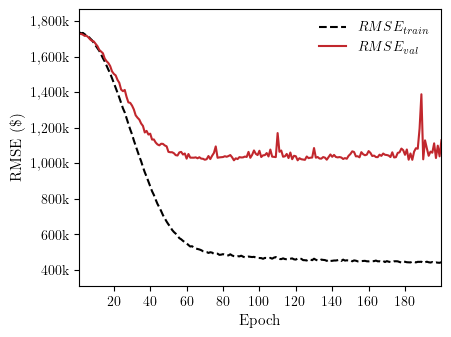

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

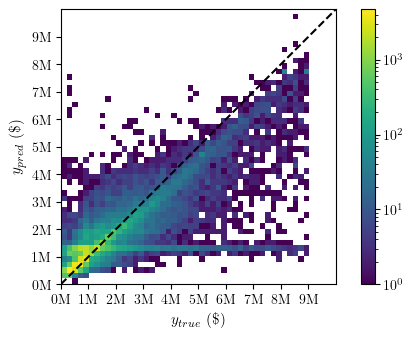

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')